In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [4]:
batch_size = 90
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


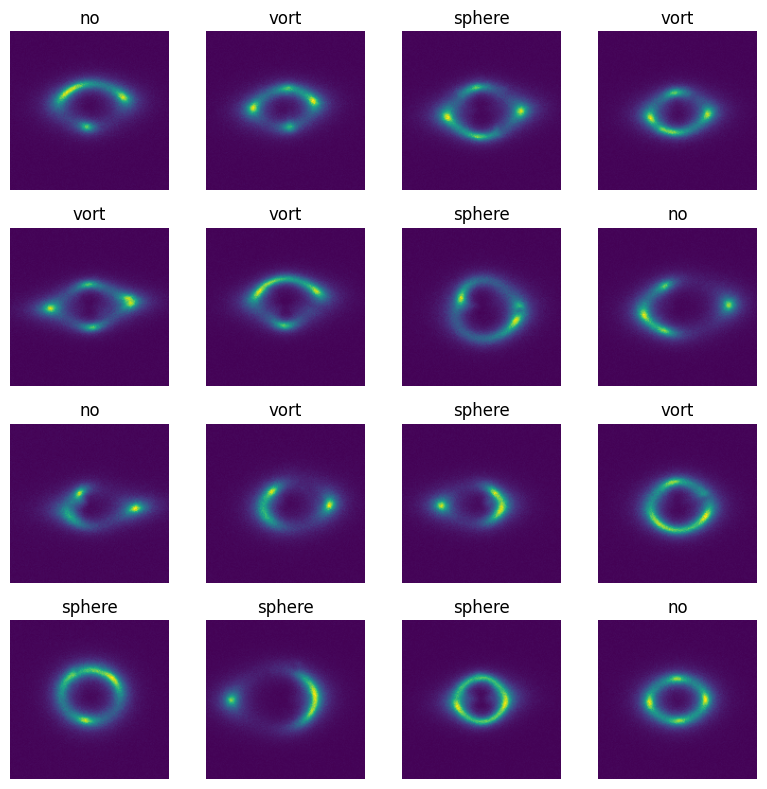

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [7]:
next(iter(train_loader))[0].shape

torch.Size([60, 1, 150, 150])

In [30]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, save_path='../best_param_CvT_1.pt'):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs).logits
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            train_corrects += torch.sum(idx == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).logits
                preds = F.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, idx = torch.max(preds, 1)
                val_corrects += torch.sum(idx == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load(save_path))

    return model

In [33]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            total_corrects += torch.sum(idx == labels).item()

            y_pred_probs.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [10]:
from transformers import CvtForImageClassification, CvtConfig

configuration = CvtConfig()
model = CvtForImageClassification(configuration)
model.config.id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
model.config.label2id = {'no': 0, 'sphere': 1, 'vort': 2}
model.cvt.encoder.stages[0].embedding.convolution_embeddings.projection = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
model.classifier = nn.Linear(384, 3, True)
# model.cvt.encoder.stages[2].layers = model.cvt.encoder.stages[2].layers[:-6]
model.to(device)

model

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Load checkpoint 1
model.load_state_dict(torch.load('../best_param_CvT_1.pt'))

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
criterion = nn.CrossEntropyLoss()

model = train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, save_path='../best_param_CvT_2.pt')
print('Finished')

Epoch 1/20:
	Train Loss: 1.1284	Train Acc: 0.3307
	Val Loss: 1.1025	Val Acc: 0.3420
Epoch 2/20:
	Train Loss: 1.1098	Train Acc: 0.3349
	Val Loss: 1.1213	Val Acc: 0.3420
Epoch 3/20:
	Train Loss: 1.1087	Train Acc: 0.3400
	Val Loss: 1.1022	Val Acc: 0.3140
Epoch 4/20:
	Train Loss: 1.1095	Train Acc: 0.3309
	Val Loss: 1.1042	Val Acc: 0.3223
Epoch 5/20:
	Train Loss: 1.1089	Train Acc: 0.3341
	Val Loss: 1.1035	Val Acc: 0.3420
Epoch 6/20:
	Train Loss: 1.1105	Train Acc: 0.3297
	Val Loss: 1.1210	Val Acc: 0.3133
Epoch 7/20:
	Train Loss: 1.1084	Train Acc: 0.3310
	Val Loss: 1.1024	Val Acc: 0.3440
Epoch 8/20:
	Train Loss: 1.1021	Train Acc: 0.3406
	Val Loss: 1.0978	Val Acc: 0.3523
Epoch 9/20:
	Train Loss: 1.0970	Train Acc: 0.3601
	Val Loss: 1.0955	Val Acc: 0.3590
Epoch 10/20:
	Train Loss: 1.0921	Train Acc: 0.3621
	Val Loss: 1.1002	Val Acc: 0.3587
Epoch 11/20:
	Train Loss: 1.0857	Train Acc: 0.3780
	Val Loss: 1.1827	Val Acc: 0.3577
Epoch 12/20:
	Train Loss: 1.0833	Train Acc: 0.3796
	Val Loss: 1.0864	Val A

In [14]:
# Load checkpoint 2
model.load_state_dict(torch.load('../best_param_CvT_2.pt'))

<All keys matched successfully>

In [18]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
criterion = nn.CrossEntropyLoss()

model = train_model(model, criterion, optimizer, scheduler, num_epochs=20, save_path='../best_param_CvT_1.pt')
print('Finished')

Epoch 1/20:
	Train Loss: 1.0095	Train Acc: 0.4588
	Val Loss: 1.0147	Val Acc: 0.4890
Epoch 2/20:
	Train Loss: 0.9990	Train Acc: 0.4774
	Val Loss: 1.2347	Val Acc: 0.4113
Epoch 3/20:
	Train Loss: 0.9931	Train Acc: 0.4746
	Val Loss: 1.0485	Val Acc: 0.4300
Epoch 4/20:
	Train Loss: 0.9917	Train Acc: 0.4757
	Val Loss: 0.9716	Val Acc: 0.4920
Epoch 5/20:
	Train Loss: 1.0788	Train Acc: 0.3721
	Val Loss: 1.1084	Val Acc: 0.3133
Epoch 6/20:
	Train Loss: 0.9927	Train Acc: 0.4760
	Val Loss: 1.0412	Val Acc: 0.4490
Epoch 7/20:
	Train Loss: 0.9875	Train Acc: 0.4834
	Val Loss: 0.9593	Val Acc: 0.5157
Epoch 8/20:
	Train Loss: 0.9813	Train Acc: 0.4871
	Val Loss: 1.5990	Val Acc: 0.3780
Epoch 9/20:
	Train Loss: 1.0388	Train Acc: 0.4259
	Val Loss: 1.0989	Val Acc: 0.3363
Epoch 10/20:
	Train Loss: 0.9835	Train Acc: 0.4817
	Val Loss: 0.9713	Val Acc: 0.4970
Epoch 11/20:
	Train Loss: 0.9321	Train Acc: 0.5158
	Val Loss: 0.9050	Val Acc: 0.5520
Epoch 12/20:
	Train Loss: 0.9207	Train Acc: 0.5241
	Val Loss: 0.9064	Val A

In [ ]:
# Load checkpoint 1
model.load_state_dict(torch.load('../best_param_CvT_1.pt'))

In [28]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
criterion = nn.CrossEntropyLoss()

model = train_model(model, criterion, optimizer, scheduler, num_epochs=50, save_path='../best_param_CvT_2.pt')
print('Finished')

Epoch 1/50:
	Train Loss: 0.9130	Train Acc: 0.5289
	Val Loss: 0.8972	Val Acc: 0.5503
Epoch 2/50:
	Train Loss: 0.9062	Train Acc: 0.5340
	Val Loss: 0.8971	Val Acc: 0.5507
Epoch 3/50:
	Train Loss: 0.9075	Train Acc: 0.5327
	Val Loss: 0.8930	Val Acc: 0.5510
Epoch 4/50:
	Train Loss: 0.9056	Train Acc: 0.5311
	Val Loss: 0.8897	Val Acc: 0.5503
Epoch 5/50:
	Train Loss: 0.9074	Train Acc: 0.5316
	Val Loss: 0.8894	Val Acc: 0.5497
Epoch 6/50:
	Train Loss: 0.9050	Train Acc: 0.5356
	Val Loss: 0.8921	Val Acc: 0.5517
Epoch 7/50:
	Train Loss: 0.8987	Train Acc: 0.5380
	Val Loss: 0.8890	Val Acc: 0.5583
Epoch 8/50:
	Train Loss: 0.8985	Train Acc: 0.5380
	Val Loss: 0.8865	Val Acc: 0.5493
Epoch 9/50:
	Train Loss: 0.9015	Train Acc: 0.5367
	Val Loss: 0.8885	Val Acc: 0.5507
Epoch 10/50:
	Train Loss: 0.9032	Train Acc: 0.5357
	Val Loss: 0.8869	Val Acc: 0.5560
Epoch 11/50:
	Train Loss: 0.8992	Train Acc: 0.5387
	Val Loss: 0.8863	Val Acc: 0.5557
Epoch 12/50:
	Train Loss: 0.8971	Train Acc: 0.5393
	Val Loss: 0.8858	Val A

KeyboardInterrupt: 

Test Loss: 0.8663
Accuracy: 0.5792
ROC AUC: 0.7548


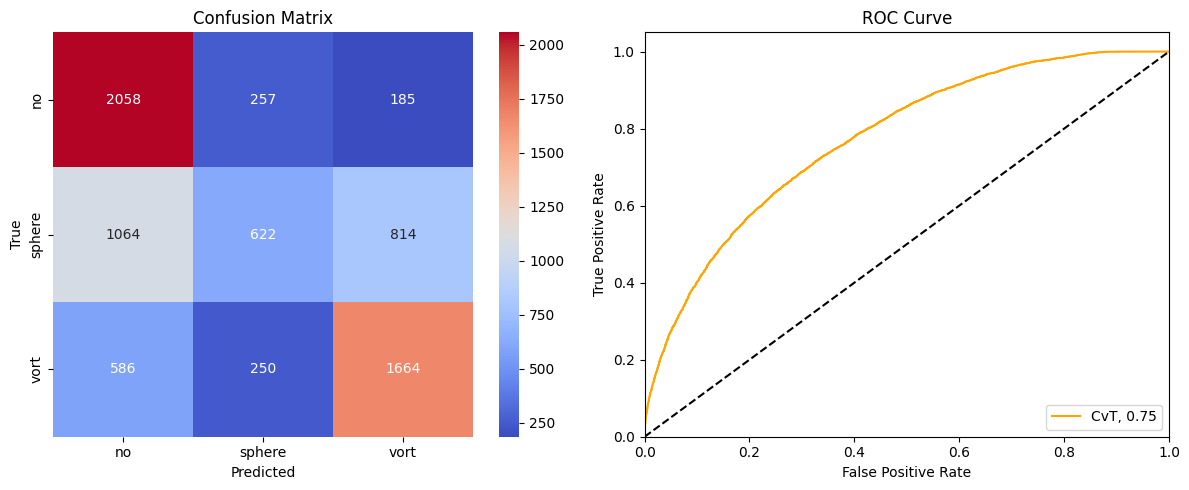

In [34]:
evaluate_model(model, criterion, 'CvT')